# Model for Italian data, aggregated over regions

In [1]:
import torch as th
import pandas as pd
import numpy as np
from git_root import git_root
import matplotlib.pylab as plt
import sys
import os
import seaborn as sns
from datetime import timedelta
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from src.utils import train_model

In [3]:
%load_ext autoreload
%autoreload 2

## Load and prepare data

In [4]:
df = pd.read_csv(os.path.join(git_root(), "data", "df_it.csv"))

In [5]:
df[["date", "region_name", "cases_pos_new", "cases_pos_total"]].head()

,date,region_name,cases_pos_new,cases_pos_total
0,2020-02-24 18:00:00,Abruzzo,0,0
1,2020-02-24 18:00:00,Veneto,32,32
2,2020-02-24 18:00:00,Valle d'Aosta,0,0
3,2020-02-24 18:00:00,Umbria,0,0
4,2020-02-24 18:00:00,P.A. Trento,0,0


## Prepare data

In [8]:
df_agg = df.groupby("date").agg({"cases_pos_hospitalized_icu": "sum"}).reset_index()
df_agg["cases_pos_hospitalized_icu_change"] = df_agg["cases_pos_hospitalized_icu"].diff()

In [9]:
x = df_agg["cases_pos_hospitalized_icu"].to_numpy()[1:-1]
x_t = df_agg["cases_pos_hospitalized_icu_change"].to_numpy()[1:-1]
y = df_agg["cases_pos_hospitalized_icu_change"].to_numpy()[2:]

### Spec 1: unit root

In [10]:
model = train_model(x, y, x_t, learning_rate=1e-3, print_every=500, n_epochs=2000, which_model="unit_root")

epoch = 0, train error = 89.25947
epoch = 500, train error = -424.52182
epoch = 1000, train error = -424.66916
epoch = 1500, train error = -424.68747


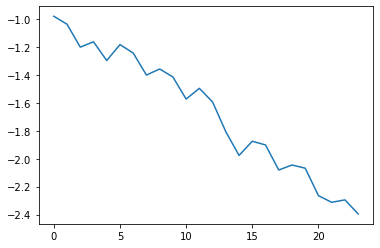

In [9]:
lam, omega_pred = model(th.tensor(x).float(), th.tensor(x_t).float())
plt.plot(omega_pred)

In [10]:
horizon = 5
pred = model.predict(th.tensor(x).float(), th.tensor(x_t).float(), horizon=horizon)

In [11]:
len(np.append(y, np.full(horizon, fill_value=np.nan)))

29

In [12]:
df_pred = pd.DataFrame({"t": np.arange(1, 1 + len(pred)), "cases_predicted": pred, "cases_pos_hospitalized_icu_change": np.append(y, np.full(horizon+1, fill_value=np.nan))})
df_pred = pd.melt(df_pred, id_vars="t")

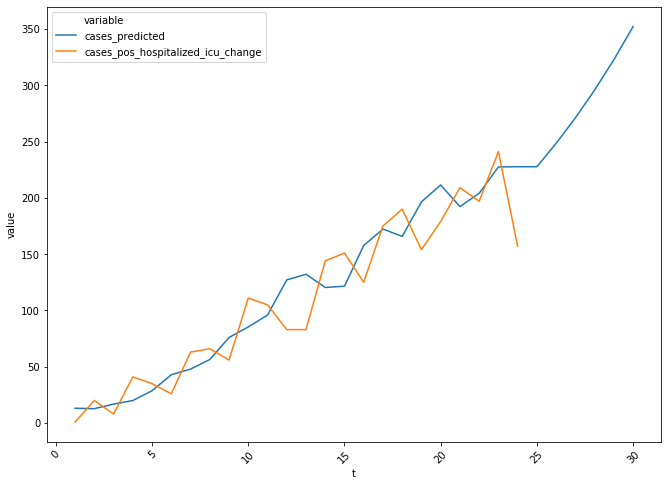

In [13]:
fig, ax = plt.subplots(figsize=(11, 8))
plt.xticks(rotation=45)
sns.lineplot(ax = ax, data=df_pred, x="t", y="value", hue="variable")

In [14]:
model.omega0, model.gamma

(Parameter containing:
 tensor(-0.9787, requires_grad=True),
 Parameter containing:
 tensor(0.0499, requires_grad=True))

### Spec 2: stationary process for $\omega$

In [11]:
model = train_model(x, y, x_t, learning_rate=1e-3, print_every=500, n_epochs=2000, which_model="stationary")

epoch = 0, train error = 89.25947
epoch = 500, train error = -424.26575
epoch = 1000, train error = -424.26575
epoch = 1500, train error = -424.26575


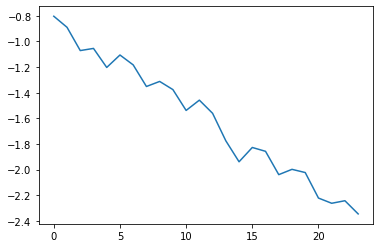

In [12]:
lam, omega_pred = model(th.tensor(x).float(), th.tensor(x_t).float())
plt.plot(omega_pred)

In [13]:
horizon = 5
pred = model.predict(th.tensor(x).float(), th.tensor(x_t).float(), horizon=horizon)

In [14]:
len(np.append(y, np.full(horizon, fill_value=np.nan)))

29

In [15]:
df_pred = pd.DataFrame({"t": np.arange(1, 1 + len(pred)), "cases_predicted": pred, "cases_pos_hospitalized_icu_change": np.append(y, np.full(horizon+1, fill_value=np.nan))})
df_pred = pd.melt(df_pred, id_vars="t")

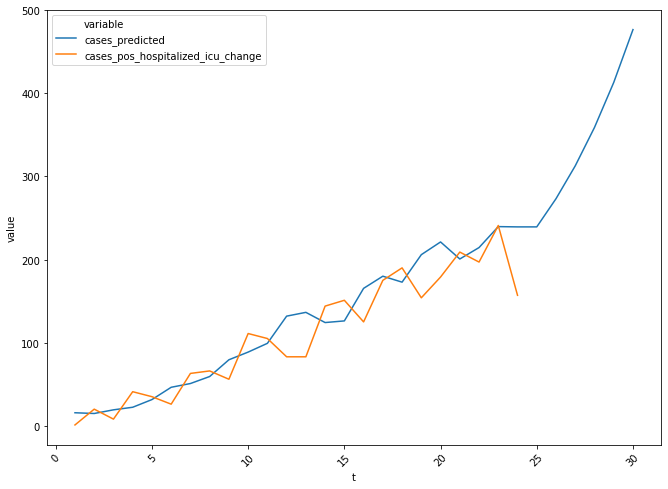

In [16]:
fig, ax = plt.subplots(figsize=(11, 8))
plt.xticks(rotation=45)
sns.lineplot(ax = ax, data=df_pred, x="t", y="value", hue="variable")

In [17]:
model.alpha, model.beta, model.gamma

(Parameter containing:
 tensor(-0.0214, requires_grad=True),
 Parameter containing:
 tensor(0.9734, requires_grad=True),
 Parameter containing:
 tensor(0.0512, requires_grad=True))